In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from joblib import dump, load

from pyod.models.abod import ABOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.utils.utility import precision_n_scores, standardizer
from sklearn.metrics import auc, f1_score, roc_auc_score, roc_curve

from autocustom import AutoEncoderCustom

from datautil import *
import config

In [14]:
config_dict = config.get_config_dict()
dataset_name = config_dict['dataset_name']
outlier_fraction = config_dict['outlier_fraction']
num_clients_per_class = config_dict['num_clients_per_class']
association_threshold = config_dict['association_threshold']
random_state = config_dict['seed']

x_train, y_train, x_test, y_test = get_dataset(dataset_name, flatten_and_normalize=True)

n_features = np.prod(x_train.shape[1:])
num_classes = np.unique(y_train).size

print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [15]:
# dict of dataset, 
# key of the dataset is "X_Y" where X is the inlier class (most common) and Y is just an increasing number
# key will be client name
datasets = partition(x_train,y_train, num_clients_per_class, outlier_fraction, random_state)

In [16]:
%%capture
# verify
datasets.keys()
datasets['0_1']['y_class'].value_counts()
datasets['9_8']['y_out'].value_counts()

In [17]:
# convert to object Dev objects
devs = []
for name, data, in datasets.items():
    #print(name,dataset_name)
    x = data.iloc[:,:n_features]
    y_class = data['y_class']
    devs = devs + [Dev(name, dataset_name, x, y_class)]

In [18]:
%%capture
# fit and save local models
# for coherent APIs, we use pyod models as local anomaly detectors
for dev in devs:
    dev.model_fit(
        OCSVM(contamination=outlier_fraction,cache_size=1000), # OCSVM pyod implementation. Uses sklearn under the hood
        #AutoEncoder(contamination=outlier_fraction, hidden_neurons = [16, 8, 16], dropout_rate=0.1, verbose=0, preprocessing=False), 
        #AutoEncoderCustom(contamination=outlier_fraction, verbose=1, preprocessing=False), # a custom model (see autocustom.py). Extends a base pyod model
        num_clients_per_class=num_clients_per_class, reset=False,
        )

In [19]:
%%capture
# use others models to classify local data
for dev in devs: 
    dev.set_other_models(devs)

UsageError: Line magic function `%%capture` not found.


In [20]:
%%capture
tot = {}
for dev in devs:
    tot[dev] = dev.get_senders_perc_normal()
dm = pd.DataFrame.from_dict(tot)
dm.style.background_gradient(cmap='Blues', axis=None)

AttributeError: 'Dev' object has no attribute 'senders'

In [ ]:
%%capture
# verify clients and associated candidates
for m in devs:
    devs_federated = m.get_devs_federated(association_threshold)
    print(m, end='--->')
    print(*devs_federated, sep=', ')

In [ ]:
%%capture
# graphical verification of inliner/outlier ratios
idd=40
devs[idd]
m = devs[idd].get_senders_perc_normal()
pd.DataFrame.from_dict(m, orient='index').plot.bar(figsize=(20,10))

In [ ]:
# write graph file in ncol format

#filegraph = dataset_name + '.ncol'
filegraph = 'graph.ncol' # use this temp file. Careful for parallel execution
with open(filegraph, 'w') as f:
    for m in devs:
        devs_federated = m.get_devs_federated(association_threshold)
        for i in devs_federated:
            if i != m or len(devs_federated)==1: # isolated verted
                _ = f.write(str(m) + ' ' + str(i) + '\n') # _ avoid print interactive interpreter

In [ ]:
# read the graph file

from igraph import *
association_graph = read(filegraph, format = "ncol", directed = True)
#summary(association_graph, verbosity = 1, max_rows = 25, edge_list_format = "edgelist")
#print(association_graph.vcount())

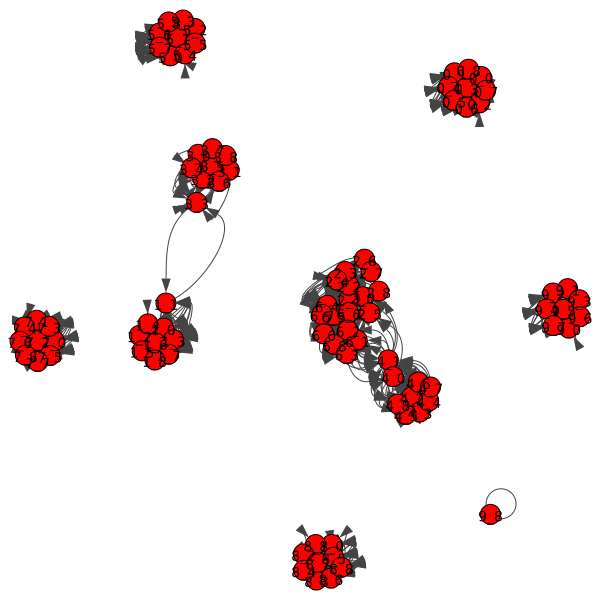

In [ ]:
# Compute the layout, using one of the possible methods (Fructherman-Reingold)
association_graph.vs["label"] = association_graph.vs["name"]
layout = association_graph.layout_fruchterman_reingold()

# Plot the graph
plot(association_graph, layout = layout)

9

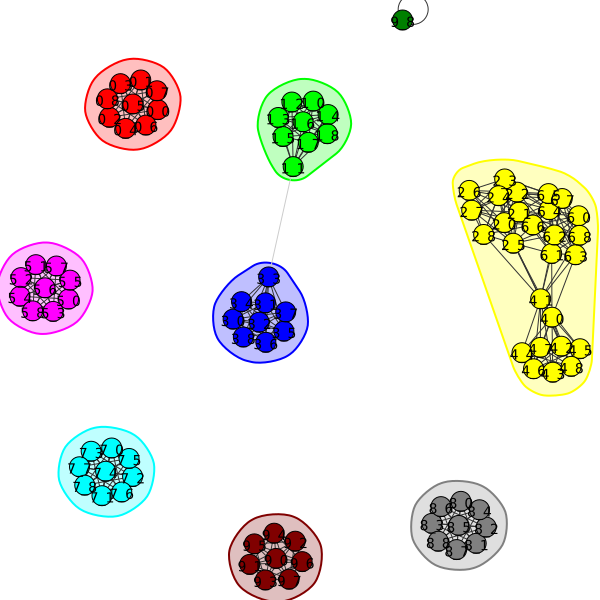

array([72])

Clustering with 90 elements and 9 clusters
0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8
1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8
3_3, 3_0, 3_1, 3_2, 3_4, 3_5, 3_6, 3_7, 3_8
2_0, 2_1, 2_2, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8, 4_1, 6_4, 6_5, 6_6, 6_7, 6_0, 6_1, 6_2, 6_8, 4_0, 4_2, 4_3, 4_4, 4_5, 4_6, 4_7, 4_8, 6_3
5_0, 5_1, 5_2, 5_3, 5_4, 5_5, 5_6, 5_7, 5_8
7_0, 7_1, 7_2, 7_3, 7_4, 7_5, 7_6, 7_7, 7_8
8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8
9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7
9_8


In [ ]:
association_graph_u = association_graph.as_undirected(combine_edges = "sum")
idx = np.argwhere(np.array(association_graph_u.degree())>0).flatten()
sub_g1 = association_graph_u.induced_subgraph(idx)

# Fastgreedy algorithm
vd = sub_g1.community_fastgreedy()

# The number of detected communities
vd.optimal_count

# convert to a cluster object to plot it nicely
vd_clust = vd.as_clustering()
plot(vd_clust, layout=sub_g1.layout_fruchterman_reingold(), mark_groups = True)

# identify the indices of edges that cut across different communities
cros = np.array(vd_clust.crossing())
np.argwhere(cros == True).flatten()
summary(vd_clust, verbosity = 1)
#summary(vd, verbosity = 1)

In [ ]:
st = vd_clust.summary(verbosity=1)
# remove the first line of the string
st = st[st.find('\n')+1:]
clust_file_name = dataset_name + str(num_clients_per_class) + '_communities.txt'
with open(clust_file_name, 'w') as f:
    _ = f.write(st) # _ avoid print interactive interpreter
